# Introduction to time series forecasting

Predict bike sharing demand

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error

In [100]:
# Import datasets
train = pd.read_csv('/Users/vinhnguyen/Downloads/train.csv')

In [101]:
print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [103]:
# Convert to datetime format
train.datetime = pd.to_datetime(train.datetime)

In [104]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


### Decompose the time series into trend, seasonality and noise

In [105]:
def decompose_serie(df, target, model, samples=1000, period=24):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[target].values, model=model, period=period)
    else:
        #decomposing a sample of the time series (take the n-samples last ones)
        res = seasonal_decompose(df[target].values[-samples:], model=model, period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid() # Add a grid on the subplot
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

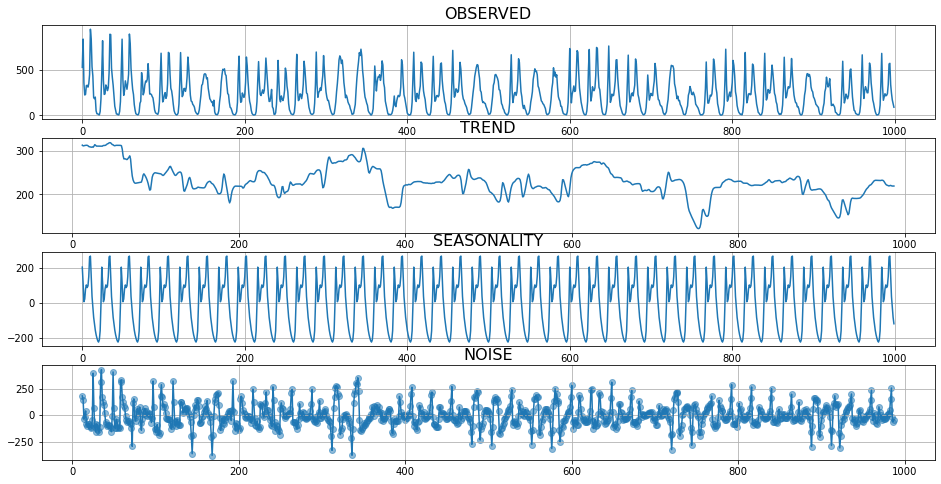

In [106]:
decompose_serie(train, "count", "additive", samples=1000, period=24)

### Time Series Forecasting using LGBM

In [107]:
#set datetime as index
train = train.set_index(train.datetime)

#drop datetime column
train.drop('datetime', axis=1, inplace=True)

#create hour, day and month variables from datetime index
train['month'] = train.index.month
train['day'] = train.index.day
train['hour'] = train.index.hour

#drop casual and registered columns for simplicty cuz count = casual + registered
train.drop(['casual', 'registered'], axis=1, inplace=True)

In [108]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,day,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,1,1,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,1,1,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,1,1,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,1,1,4


### Predict without lags

In [109]:
def train_time_series(df, target, horizon=24*7): 
    X = df.drop(target, axis=1)
    y = df[target]
    
    #take last week of the dataset for validation
    X_train, X_valid = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_valid = y.iloc[:-horizon], y.iloc[-horizon:]
    
    #create, train and do inference of the model
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    
    #calculate MAE
    mae = np.round(mean_absolute_error(y_valid, predictions), 3)    
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,8))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_valid, color='red')
    plt.plot(pd.Series(predictions, index=y_valid.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Number of Shared Bikes', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()


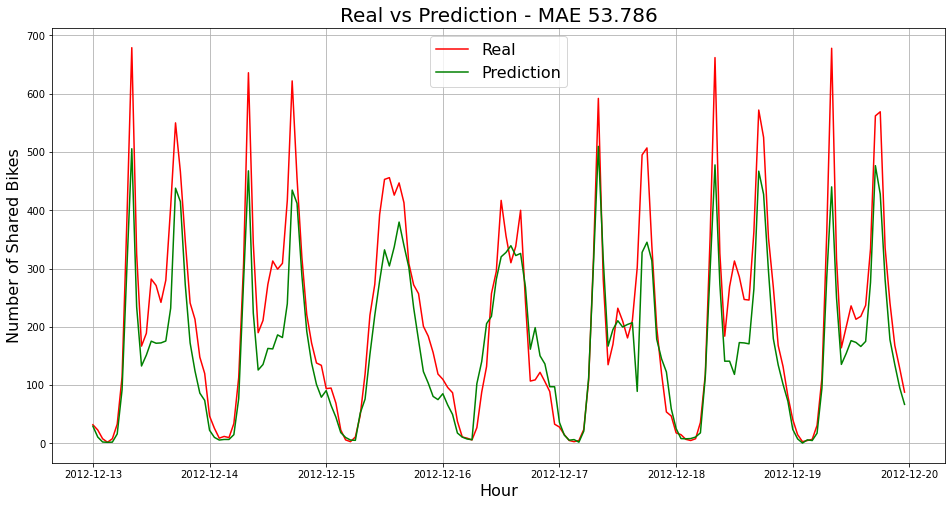

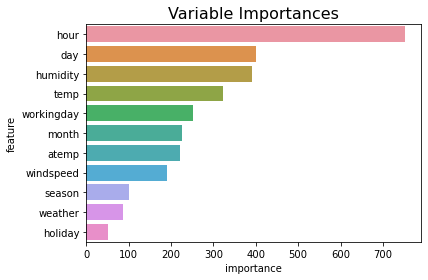

In [110]:
train_time_series(train, 'count', horizon=24*7)


### Predict with lags

In [111]:
#create 1 week lag variable by shifting the target value for 1 week
train['count_prev_week_same_hour'] = train['count'].shift(24*7)

#drop NaNs after feature engineering
train.dropna(how='any', axis=0, inplace=True)

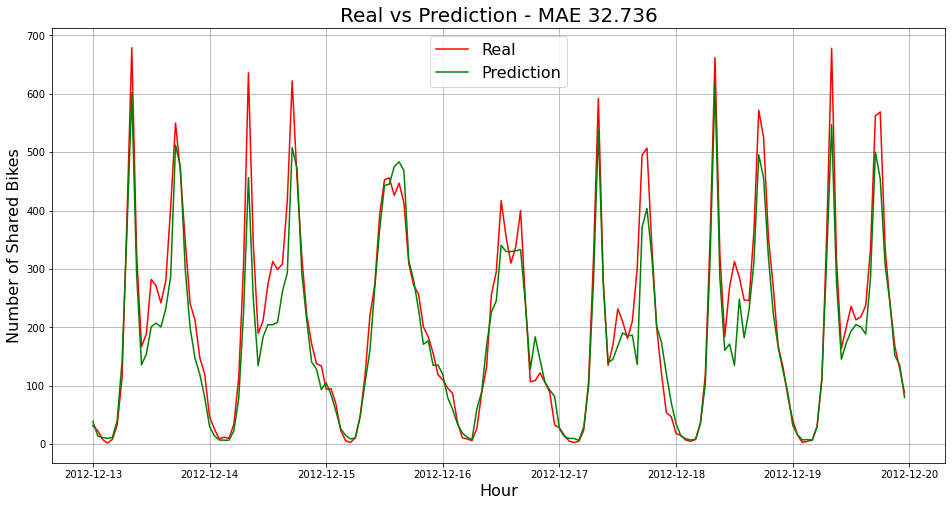

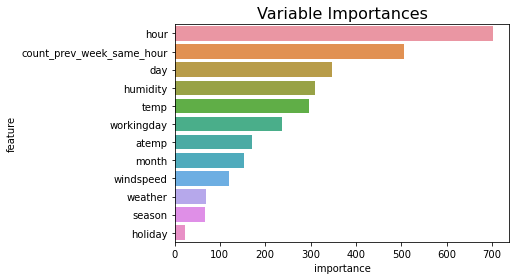

In [112]:
train_time_series(train, 'count', horizon=24*7)